In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB 51.6 MB/s eta 0:00:48
     ---------------------------------------- 0.0/2.4 GB 59.0 MB/s eta 0:00:41
      --------------------------------------- 0.0/2.4 GB 61.5 MB/s eta 0:00:40
      --------------------------------------- 0.1/2.4 GB 62.6 MB/s eta 0:00:39
     - -------------------------------------- 0.1/2.4 GB 63.0 MB/s eta 0:00:38
     - -------------------------------------- 0.1/2.4 GB 62.6 MB/s eta 0:00:38
     - -------------------------------------- 0.1/2.4 GB 62.9 MB/s eta 0:00:38
     - -------------------------------------- 0.1/2.4 GB 62.9 MB/s eta 0:00:38
     - -------------------------------------- 0.1/2.4 GB 62.7 MB/s eta 0:00:38
     -- ------------------------------------- 0.1/2.4 GB 62.9 MB/s eta 0:00:37
     -- ------------------------------------- 0.1/2.4 GB 63.6 MB/s eta 0:00:37
 

In [1]:
#For importing PyTorch and see if GPU is available
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using", device, "device")

Using cuda device


In [27]:
#%pip install transformers
#%pip install numpy scipy scikit-learn pandas matplotlib
#%pip install imblearn
#%pip install nltk
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re
import nltk
from nltk import word_tokenize
import numpy as np
import os
import json
import csv
import pandas as pd
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

from tqdm import tqdm
import time

In [5]:
file_path = 'Sarcasm_Headlines_Dataset.json'
df = pd.read_json(file_path, lines=True)

In [6]:
df.head

<bound method NDFrame.head of        is_sarcastic                                           headline  \
0                 1  thirtysomething scientists unveil doomsday clo...   
1                 0  dem rep. totally nails why congress is falling...   
2                 0  eat your veggies: 9 deliciously different recipes   
3                 1  inclement weather prevents liar from getting t...   
4                 1  mother comes pretty close to using word 'strea...   
...             ...                                                ...   
28614             1       jews to celebrate rosh hashasha or something   
28615             1  internal affairs investigator disappointed con...   
28616             0  the most beautiful acceptance speech this week...   
28617             1  mars probe destroyed by orbiting spielberg-gat...   
28618             1                 dad clarifies this not a food stop   

                                            article_link  
0      https://www.the

In [7]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [8]:
def remove_emails_hashtags_mentions(text):
    pattern = re.compile(
        r'([a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,})|'
        r'(#\w+)|'
        r'(@\w+)'
    )
    return pattern.sub('', text)

In [9]:
def preprocess_text(text):
    text = str(text)
    text = remove_emails_hashtags_mentions(text)
    text = remove_emojis(text)
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [10]:
df['cleaned_headlines'] = df['headline'].apply(preprocess_text)

In [13]:
df['headline'][0]

'thirtysomething scientists unveil doomsday clock of hair loss'

In [14]:
df.shape

(28619, 4)

In [15]:
# Balance the dataset
def balance_df(df, text, target):
    ros = RandomOverSampler()
    train_x, train_y = ros.fit_resample(np.array(df[text]).reshape(-1,1), np.array(df[target]).reshape(-1,1))
    new_df = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns=[text, target])
    return new_df

sarcasm_df = balance_df(df, 'cleaned_headlines', 'is_sarcastic')

In [17]:
sarcasm_df.head()

,cleaned_headlines,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep totally nails why congress is falling ...,0
2,eat your veggies deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word stream...,1


In [18]:
# Prepare data for PyTorch
X = sarcasm_df["cleaned_headlines"].values
y = sarcasm_df['is_sarcastic'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Create a custom dataset
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Modello Roberta

In [20]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2).to(device)

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\alexc\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarni

In [24]:
# Create datasets and dataloaders
max_length = 514 # QUESTO E' DA CAPIRE BENE
train_dataset = SarcasmDataset(X_train, y_train, tokenizer, max_length)
test_dataset = SarcasmDataset(X_test, y_test, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [25]:
# Training settings
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 5

In [29]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    start_time = time.time()
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        # Update progress bar
        progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    avg_train_loss = total_loss / len(train_loader)
    end_time = time.time()
    epoch_time = end_time - start_time
    
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Average training loss: {avg_train_loss:.4f}")
    print(f"Epoch time: {epoch_time:.2f} seconds")

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    val_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print("-" * 50)

Epoch 1/5: 100%|██████████| 1499/1499 [27:17<00:00,  1.09s/it, loss=0.6903]



Epoch 1/5
Average training loss: 0.2951
Epoch time: 1637.60 seconds


Validation: 100%|██████████| 375/375 [04:09<00:00,  1.50it/s]


Validation Loss: 0.2480
Validation Accuracy: 0.9002
--------------------------------------------------


Epoch 2/5: 100%|██████████| 1499/1499 [26:43<00:00,  1.07s/it, loss=0.4244]



Epoch 2/5
Average training loss: 0.1767
Epoch time: 1603.20 seconds


Validation: 100%|██████████| 375/375 [04:06<00:00,  1.52it/s]


Validation Loss: 0.2227
Validation Accuracy: 0.9196
--------------------------------------------------


Epoch 3/5: 100%|██████████| 1499/1499 [26:33<00:00,  1.06s/it, loss=0.0126]



Epoch 3/5
Average training loss: 0.1256
Epoch time: 1593.29 seconds


Validation: 100%|██████████| 375/375 [04:06<00:00,  1.52it/s]


Validation Loss: 0.2478
Validation Accuracy: 0.9211
--------------------------------------------------


Epoch 4/5: 100%|██████████| 1499/1499 [26:33<00:00,  1.06s/it, loss=0.1787]



Epoch 4/5
Average training loss: 0.0852
Epoch time: 1593.10 seconds


Validation: 100%|██████████| 375/375 [04:05<00:00,  1.52it/s]


Validation Loss: 0.3179
Validation Accuracy: 0.9032
--------------------------------------------------


Epoch 5/5: 100%|██████████| 1499/1499 [26:46<00:00,  1.07s/it, loss=0.0069]



Epoch 5/5
Average training loss: 0.0717
Epoch time: 1606.11 seconds


Validation: 100%|██████████| 375/375 [04:14<00:00,  1.47it/s]

Validation Loss: 0.2792
Validation Accuracy: 0.9196
--------------------------------------------------


In [30]:
# Final evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [31]:
# Print classification report
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2966
           1       0.92      0.92      0.92      3028

    accuracy                           0.92      5994
   macro avg       0.92      0.92      0.92      5994
weighted avg       0.92      0.92      0.92      5994



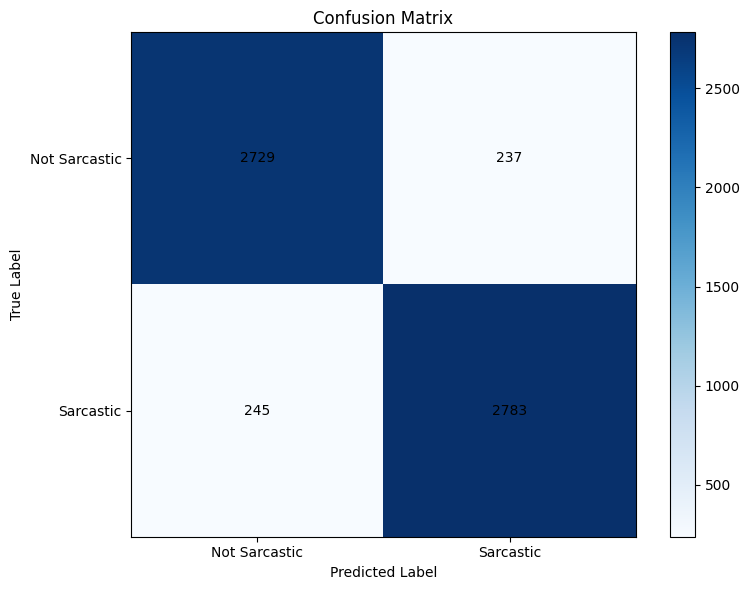

In [33]:
# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not Sarcastic', 'Sarcastic'])
plt.yticks(tick_marks, ['Not Sarcastic', 'Sarcastic'])

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [38]:
# After training and evaluation, save both the model and tokenizer
output_dir = './sarcasm_model/'
os.makedirs(output_dir, exist_ok=True)

# Save the model
torch.save(model.state_dict(), os.path.join(output_dir, "roberta_sarcasm_detection.pth"))

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

('./sarcasm_model/tokenizer_config.json',
 './sarcasm_model/special_tokens_map.json',
 './sarcasm_model/vocab.json',
 './sarcasm_model/merges.txt',
 './sarcasm_model/added_tokens.json')

In [39]:
print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to ./sarcasm_model/


In [40]:
# Example of how to load the model and tokenizer for inference
def load_model_and_tokenizer(model_dir):
    # Load the tokenizer
    loaded_tokenizer = RobertaTokenizer.from_pretrained(model_dir)
    
    # Load the model
    loaded_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
    loaded_model.load_state_dict(torch.load(os.path.join(model_dir, "roberta_sarcasm_detection.pth")))
    loaded_model.to(device)
    loaded_model.eval()
    
    return loaded_model, loaded_tokenizer

In [41]:
# Example usage
loaded_model, loaded_tokenizer = load_model_and_tokenizer(output_dir)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\alexc\AppData\Local\Temp\ipykernel_80712\331476131.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unl

In [64]:
# Function for inference
def predict_sarcasm(text, model, tokenizer):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        prediction = torch.argmax(outputs.logits, dim=1)
    
    return "Sarcastic" if prediction.item() == 1 else "Not Sarcastic"

In [65]:
sarcastic_headlines = [
    "Local man discovers secret to eternal youth: just don't age",
    "Breaking news: Water is wet, scientists confirm",
    "Study finds that eating ice cream for breakfast improves productivity, definitely not funded by Ben & Jerry's",
    "Area teenager shocked to discover that money doesn't grow on trees",
    "New diet trend: Breatharianism - just stop eating altogether!",
    "Government announces new initiative to solve poverty: 'Have you tried not being poor?'",
    "Man who has never left his hometown declares himself world travel expert",
    "Local weather forecaster predicts 'weather' for tomorrow",
    "Breaking: Politician actually keeps campaign promise, world in shock",
    "New study shows that watching paint dry is the most exciting sport"
]

for headline in sarcastic_headlines:
    result = predict_sarcasm(headline, loaded_model, loaded_tokenizer)
    print(f"Headline: '{headline}'\nPrediction: {result}\n")

Headline: 'Local man discovers secret to eternal youth: just don't age'
Prediction: Sarcastic

Headline: 'Breaking news: Water is wet, scientists confirm'
Prediction: Not Sarcastic

Headline: 'Study finds that eating ice cream for breakfast improves productivity, definitely not funded by Ben & Jerry's'
Prediction: Sarcastic

Headline: 'Area teenager shocked to discover that money doesn't grow on trees'
Prediction: Sarcastic

Headline: 'New diet trend: Breatharianism - just stop eating altogether!'
Prediction: Not Sarcastic

Headline: 'Government announces new initiative to solve poverty: 'Have you tried not being poor?''
Prediction: Sarcastic

Headline: 'Man who has never left his hometown declares himself world travel expert'
Prediction: Sarcastic

Headline: 'Local weather forecaster predicts 'weather' for tomorrow'
Prediction: Sarcastic

Headline: 'Breaking: Politician actually keeps campaign promise, world in shock'
Prediction: Sarcastic

Headline: 'New study shows that watching pai